# fit light curve of supernova using pymc3

In [1]:
import pymc3 as pm

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## learn to use pymc3

### define a simple linear model

$$ y = a x + b$$

assume prior distribution 


In [2]:
# simulate some observed data

def ylin(x, a, b):
    
    y_model = a*x + b
    return y_model

n = 20  # number of data
a = 6   # true value of a 
b = 2   # true value of b

x = np.linspace(0, 10, n)

np.random.seed(123)
y = ylin(x, a, b) + np.random.randn(n) # add some error use random

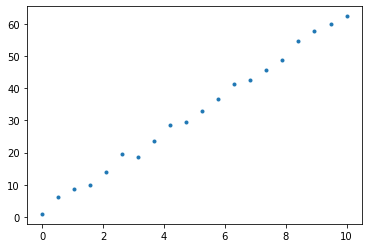

In [3]:
plt.plot(x, y, '.')

### fit by mcmc

In [4]:
# data
x_dat = x
y_dat = y

linreg = pm.Model()
with linreg:
    # prior distribution
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # expected value from model
    # y_model = a*x_dat + b
    y_model = ylin(x_dat, a, b)
    
    likelihood = pm.Normal('', mu=y_model, sd=sigma, observed=y_dat)
    

In [5]:
with linreg:
    trace = pm.sample(10000, random_seed=123, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:16<00:00, 2604.75draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff574af2400>,
      dtype=object)

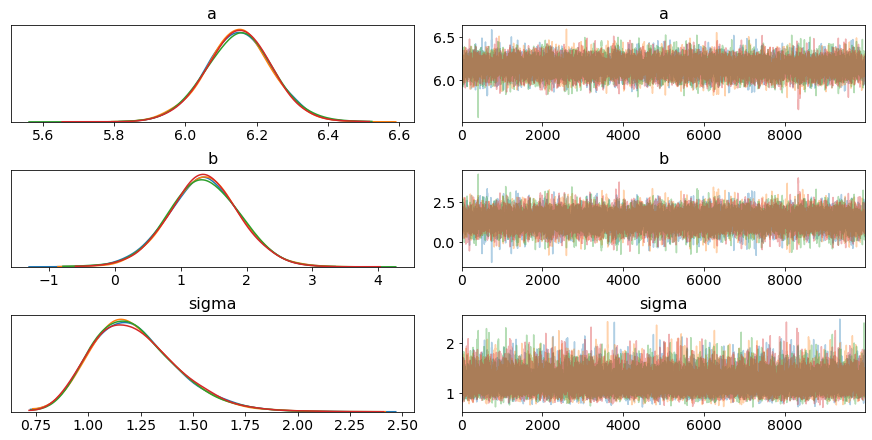

In [6]:
pm.traceplot(trace)

In [7]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,6.150790,0.091653,0.000622,5.967462,6.330725,16125.043415,1.000027
b,1.358784,0.536786,0.003655,0.314970,2.428023,15931.773670,1.000068
sigma,1.227676,0.203901,0.001307,0.877674,1.643957,21952.100287,0.999979


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        9.000e+00, 1.800e+01, 3.100e+01, 5.800e+01, 9.000e+01, 1.660e+02,
        3.020e+02, 4.320e+02, 6.700e+02, 9.030e+02, 1.222e+03, 1.749e+03,
        2.279e+03, 2.739e+03, 3.231e+03, 3.604e+03, 3.659e+03, 3.697e+03,
        3.523e+03, 2.898e+03, 2.384e+03, 1.931e+03, 1.409e+03, 1.026e+03,
        7.070e+02, 4.900e+02, 3.000e+02, 1.640e+02, 1.200e+02, 6.100e+01,
        4.800e+01, 3.500e+01, 1.700e+01, 7.000e+00, 7.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00]),
 array([5.56141684, 5.58198147, 5.6025461 , 5.62311073, 5.64367536,
        5.66423998, 5.68480461, 5.70536924, 5.72593387, 5.7464985 ,
        5.76706313, 5.78762775, 5.80819238, 5.82875701, 5.84932164,
        5.86988627, 5.8904509 , 5.91101552, 5.93158015, 5.95214478,
        5.97270941, 5.99327404, 6.01383867, 6.03440329, 6.05496792,
        6.07553255, 6.09609718, 6.11

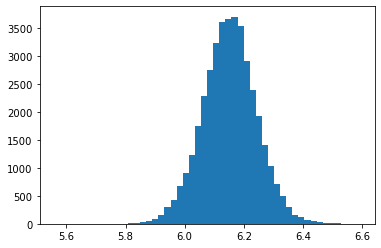

In [8]:
plt.hist(trace['a'], bins=50)

## fit nonlinear model  of supernova light curve

In [9]:
import theano.tensor as tt

In [10]:
def snModel_3_tt(t, tsh, Esh, t0):
    # use np.piecewise(x,condition list, function)

    #condlist = [t < tsh, t >=tsh]
    
    #func = [lambda t:Esh/tsh*(1-np.exp(-t/t0)), lambda t:Esh/tsh*np.exp(-t/t0)*(np.exp(tsh/t0)-1)]
      
    #return np.piecewise(t, condlist, func)
    
    # or use np.heaviside()
    #Esh/tsh*(1-np.exp(-t/t0)) * np.heaviside(tsh-t, tsh) + Esh/tsh*np.exp(-t/t0)*(np.exp(tsh/t0)-1) * np.heaviside(t-tsh, tsh)
    
    lambda_1 = Esh/tsh*(1-np.exp(-t/t0))
    lambda_2 = Esh/tsh*np.exp(-t/t0)*(np.exp(tsh/t0)-1)
    # need to use tt.switch from theano to define piecewise functions
    return tt.switch(t>tsh, lambda_2, lambda_1)

def snModel_3(t, tsh, Esh, t0):
    
    return Esh/tsh*(1-np.exp(-t/t0)) * np.heaviside(tsh-t, tsh) + Esh/tsh*np.exp(-t/t0)*(np.exp(tsh/t0)-1) * np.heaviside(t-tsh, tsh)
  

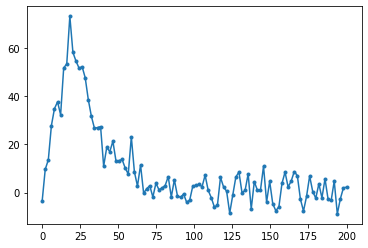

In [11]:
# simulate observed data
np.random.seed(125)

n = 100

tsh = 20
Esh = 2000

t0 = 20

a = 0
b = 1

x = np.linspace(0, 200, n)
y = snModel_3(x, tsh, Esh, t0) + 5*np.random.randn(n)

plt.plot(x, y, '.-')

In [12]:
# data
x_dat = x
y_dat = y

snreg = pm.Model()
with snreg:
    # prior distribution
    tsh = pm.Uniform('tsh', lower=0, upper=100)
    Esh = pm.Normal('Esh', mu=2000, sd=100)
    t0 = pm.Uniform('t0', lower=10, upper=100)
    
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # expected value from model
    # y_model = a*x_dat + b
    y_model = snModel_3_tt(x_dat, tsh, Esh, t0)
     
    likelihood = pm.Normal('', mu=y_model, sd=sigma, observed=y_dat)

In [13]:
with snreg:
    trace_sn = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, t0, Esh, tsh]
Sampling 4 chains: 100%|██████████| 44000/44000 [00:18<00:00, 2430.89draws/s]


In [143]:
pm.summary(trace_sn)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Esh,1973.893099,53.743501,1.466833,1875.675711,2083.237794,1482.861306,1.000049
tsh,20.357249,0.963224,0.026939,18.396588,22.126749,1178.759137,0.999503
t0,19.289795,1.302674,0.039061,16.792014,21.725156,1118.318998,0.999502
sigma,4.603209,0.277730,0.006607,4.101892,5.143360,1787.594790,0.999574


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd307f9c390>,
      dtype=object)

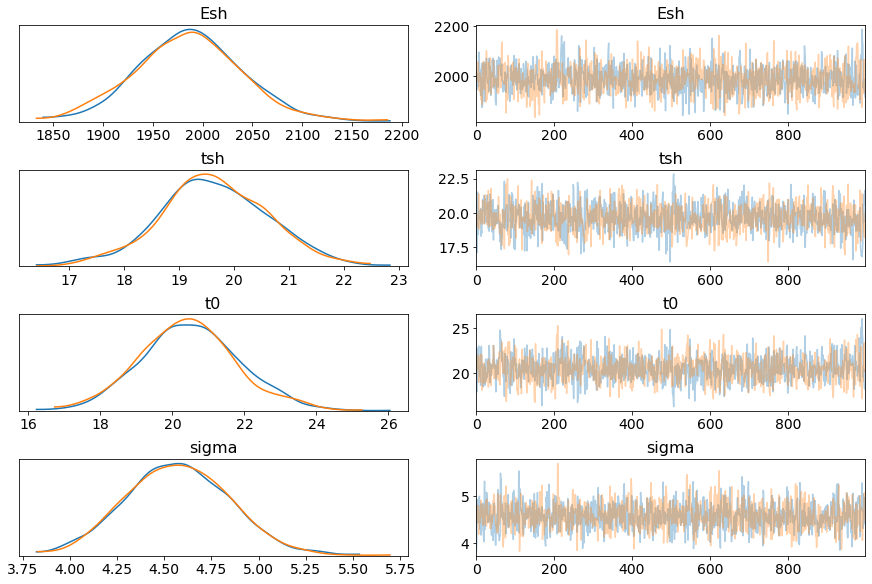

In [136]:
pm.traceplot(trace_sn)

### load type IIp light curve

In [14]:
# load light curve data
lc_IIp = np.genfromtxt('lc_IIp.txt', dtype=[('phase','f8'),('mag','f8'),('filter','S1')], delimiter=' ')

# decode byte to string
lcfilter=[]
for f in lc_IIp['filter']:
    lcfilter.append(f.decode('UTF-8'))
lcfilter = np.array(lcfilter) 
sortarray = np.argsort(lc_IIp['phase'])

# lc for a filter 'r'
fmatch = np.where(lcfilter[sortarray]=='r')
lcmagr_IIp = lc_IIp['mag'][sortarray][fmatch]

phaser_IIp = lc_IIp['phase'][sortarray][fmatch]

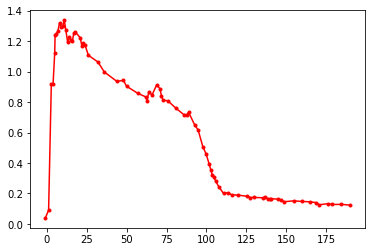

In [15]:
def mag2flux(m, m0):
    return 10**(-0.4 * (m - m0))

fluxr_IIp = mag2flux(lcmagr_IIp, 18)

plt.plot(phaser_IIp, fluxr_IIp, 'r.-')

In [16]:
# data
x_dat = phaser_IIp
y_dat = fluxr_IIp

snreg = pm.Model()
with snreg:
    # prior distribution
    tsh = pm.Uniform('tsh', lower=0, upper=100)
    Esh = pm.Normal('Esh', mu=2000, sd=100)
    t0 = pm.Uniform('t0', lower=10, upper=100)
    
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # expected value from model
    # y_model = a*x_dat + b
    y_model = snModel_3_tt(x_dat, tsh, Esh, t0)
     
    likelihood = pm.Normal('', mu=y_model, sd=sigma, observed=y_dat)

In [17]:
with snreg:
    trace_IIp = pm.sample(20000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, t0, Esh, tsh]
Sampling 4 chains: 100%|██████████| 84000/84000 [00:44<00:00, 1868.07draws/s]
The acceptance probability does not match the target. It is 0.891016077805407, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6972437356306141, but should be close to 0.8. Try to increase the number of tuning steps.


In [18]:
pm.summary(trace_IIp)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Esh,124.924652,4.494799,0.026614,116.151929,133.794376,27694.569116,1.000047
tsh,6.040795,0.449038,0.002071,5.165984,6.919493,47001.532877,0.999998
t0,85.227498,4.114080,0.025694,77.395848,93.497149,26440.057350,0.999998
sigma,0.130250,0.011045,0.000047,0.109622,0.152385,45266.556431,0.999982


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff56c94b978>,
      dtype=object)

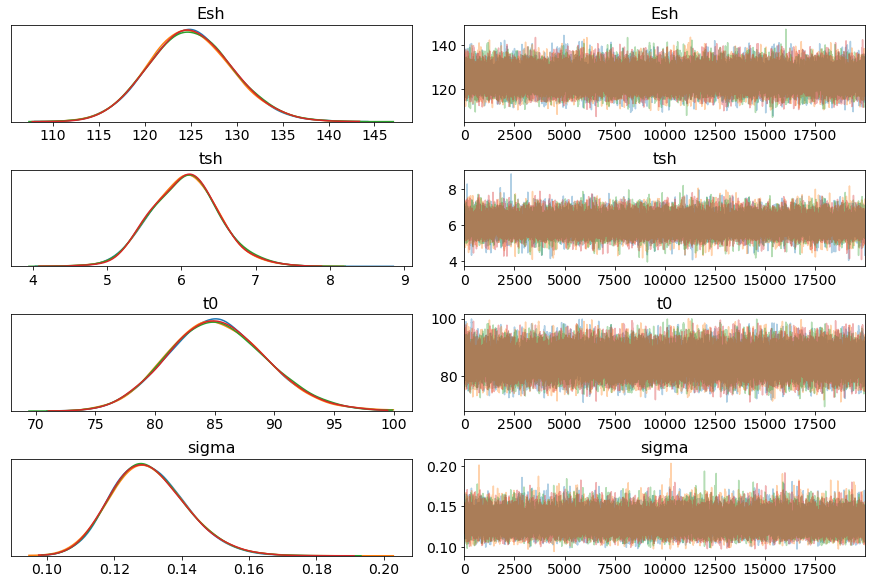

In [19]:
pm.traceplot(trace_IIp)

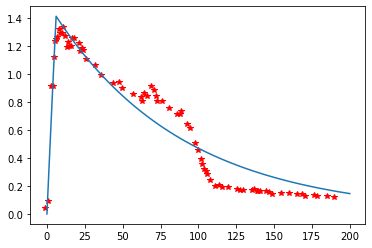

In [20]:
tsh = 6.041426
Esh = 124.9246
t0 = 85.259314

x_fit = np.linspace(0, 200, n)
y_fit = snModel_3(x, tsh, Esh, t0)

plt.plot(x_dat, y_dat, 'r*', x_fit, y_fit, '-')

array([  6.12660163, 120.94875567,  81.91306112])

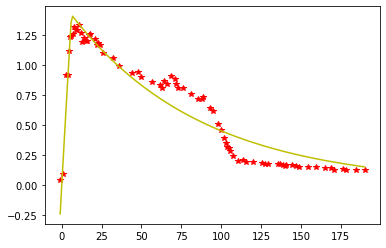

In [21]:
from scipy.optimize import curve_fit

xdat_IIp = phaser_IIp
ydat_IIp = fluxr_IIp
popt_3_IIp, pcov_3_IIp = curve_fit(snModel_3, xdat_IIp, ydat_IIp)

yfit_3_IIp = snModel_3(xdat_IIp, *popt_3_IIp)
plt.plot(xdat_IIp, ydat_IIp, 'r*', xdat_IIp, yfit_3_IIp,'y-')
popt_3_IIp

In [22]:
def snModel_6_tt(t, t1, A, t0, tau_rise, tau_fall, beta=0.1):
    
    lambda_1 = (A + beta * (t - t0)) / (1 + np.exp(-(t - t0) / tau_rise))
    lambda_2 = (A + beta * (t1 - t0)) * np.exp(-(t - t1) / tau_fall) / (1 + np.exp(-(t - t0) / tau_rise))
        
    return tt.switch(t>tsh, lambda_2, lambda_1)

def snModel_6(t, t1, A, t0, tau_rise, tau_fall, beta=0.1):
    condlist = [t < t1, t >= t1]
    
    func = [lambda t: (A + beta * (t - t0)) / (1 + np.exp(-(t - t0) / tau_rise)), 
            lambda t: (A + beta * (t1 - t0)) * 
            np.exp(-(t - t1) / tau_fall) / (1 + np.exp(-(t - t0) / tau_rise))]
    
    return np.piecewise(t, condlist, func)



In [23]:
fluxr_IIp.max()

1.3365955165464438

In [24]:
phaser_IIp

array([ -1.  ,   1.  ,   2.7 ,   3.79,   4.84,   5.07,   5.84,   6.84,
         7.84,   8.84,   9.84,  10.84,  11.84,  12.94,  13.94,  14.89,
        15.94,  16.82,  17.82,  20.86,  21.85,  22.83,  23.87,  25.94,
        31.94,  35.93,  43.88,  47.89,  49.89,  56.86,  61.82,  62.82,
        63.82,  65.82,  68.78,  70.78,  71.78,  72.78,  75.77,  80.77,
        85.74,  87.74,  88.76,  92.76,  94.73,  97.73,  99.73, 101.73,
       102.73, 103.74, 104.73, 105.73, 107.68, 110.68, 113.72, 115.72,
       119.63, 125.55, 127.55, 129.55, 135.56, 136.56, 138.71, 139.71,
       140.69, 144.65, 146.65, 148.68, 154.68, 159.68, 164.93, 168.62,
       170.68, 176.47, 178.51, 184.65, 189.86])

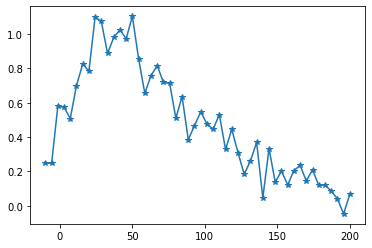

In [25]:
x = np.linspace(-10, 200)

y = snModel_6(x, t1=10, A=1.5, t0=10, tau_rise=10, tau_fall=80, beta=-0.01) + 0.1*np.random.randn(len(x))

plt.plot(x, y, '*-')

In [26]:
# data
x_dat = phaser_IIp
y_dat = fluxr_IIp

snreg_IIp = pm.Model()
with snreg_IIp:
    # prior distribution
    t1 = pm.Uniform('t1', lower=1, upper=200)
    A = pm.Uniform('A', lower=0.01, upper=2)
    t0 = pm.Uniform('t0', lower=-50, upper=50)
    tau_rise = pm.Uniform('tau_rise', lower=0.01, upper=50)
    tau_fall = pm.Uniform('tau_fall', lower=1, upper=300)
    beta = pm.Uniform('beta', lower=-1/150, upper=0)
    
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # expected value from model
    # y_model = a*x_dat + b
    y_model = snModel_6_tt(x_dat, t1, A, t0, tau_rise, tau_fall, beta)
     
    likelihood = pm.Normal('', mu=y_model, sd=sigma, observed=y_dat)

In [ ]:
with snreg_IIp:
    trace_IIp = pm.sample(50000, tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, tau_fall, tau_rise, t0, A, t1]
Sampling 4 chains:   8%|▊         | 16544/216000 [00:41<06:44, 492.87draws/s]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd3023289b0>,
      dtype=object)

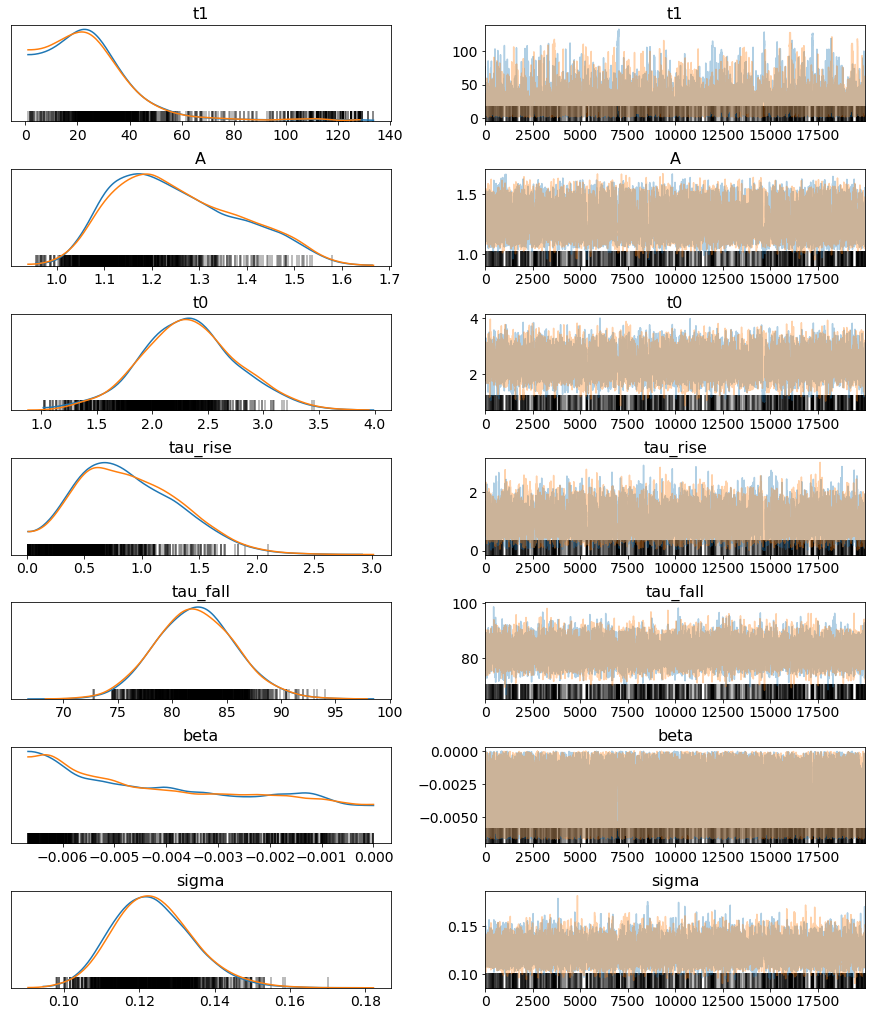

In [206]:
pm.traceplot(trace_IIp)

In [30]:
pm.summary(trace_IIp)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
t1,26.820372,22.093628,0.986823,1.000939,63.345928,368.736272,1.003577
A,1.251409,0.129617,0.002151,1.044184,1.512303,4148.620558,1.000714
t0,2.327673,0.426037,0.007861,1.494122,3.185260,3279.188761,1.000570
tau_rise,0.864378,0.450610,0.006024,0.024896,1.663177,5277.234977,1.000561
tau_fall,82.039986,3.661958,0.036110,75.019068,89.362805,12408.011445,1.000164
beta,-0.003771,0.001960,0.000030,-0.006667,-0.000430,4996.077748,1.000093
sigma,0.123487,0.010460,0.000118,0.104001,0.144434,8981.807542,1.000294


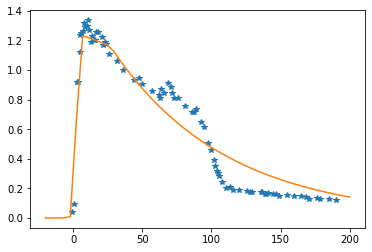

In [34]:
t1 = 26.809925
A = 1.253558
t0 = 2.325637
tau_rise = 0.878735
tau_fall = 82.113730
beta = -0.003757
x_fit = np.linspace(-20, 200)

y_fit = snModel_6(x_fit, t1, A, t0, tau_rise, tau_fall, beta)

plt.plot(x_dat, y_dat, '*', x_fit, y_fit, '-')


array([  5.22657601, 802.24966634,  97.48464905,  25.45631276,
        23.4999458 ,   8.16052491])

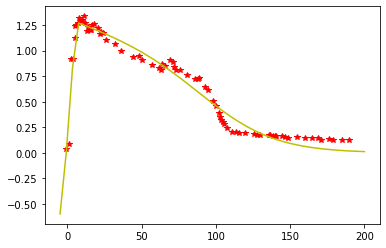

In [184]:
xdat_IIp = phaser_IIp
ydat_IIp = fluxr_IIp
popt_6_IIp, pcov_6_IIp = curve_fit(snModel_6, xdat_IIp, ydat_IIp)

xfit = np.linspace(-5, 200)
yfit_6_IIp = snModel_6(xfit, *popt_6_IIp)
plt.plot(xdat_IIp, ydat_IIp, 'r*', xfit, yfit_6_IIp,'y-')
popt_6_IIp

In [36]:
trace.varnames

['a', 'b', 'sigma_log__', 'sigma']

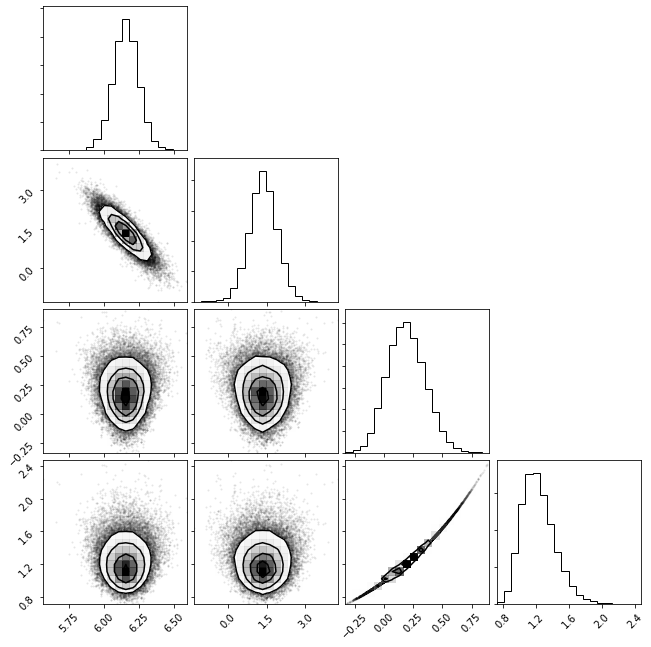

In [38]:
import corner

samples = np.vstack([trace[k] for k in trace.varnames]).T
corner.corner(samples);

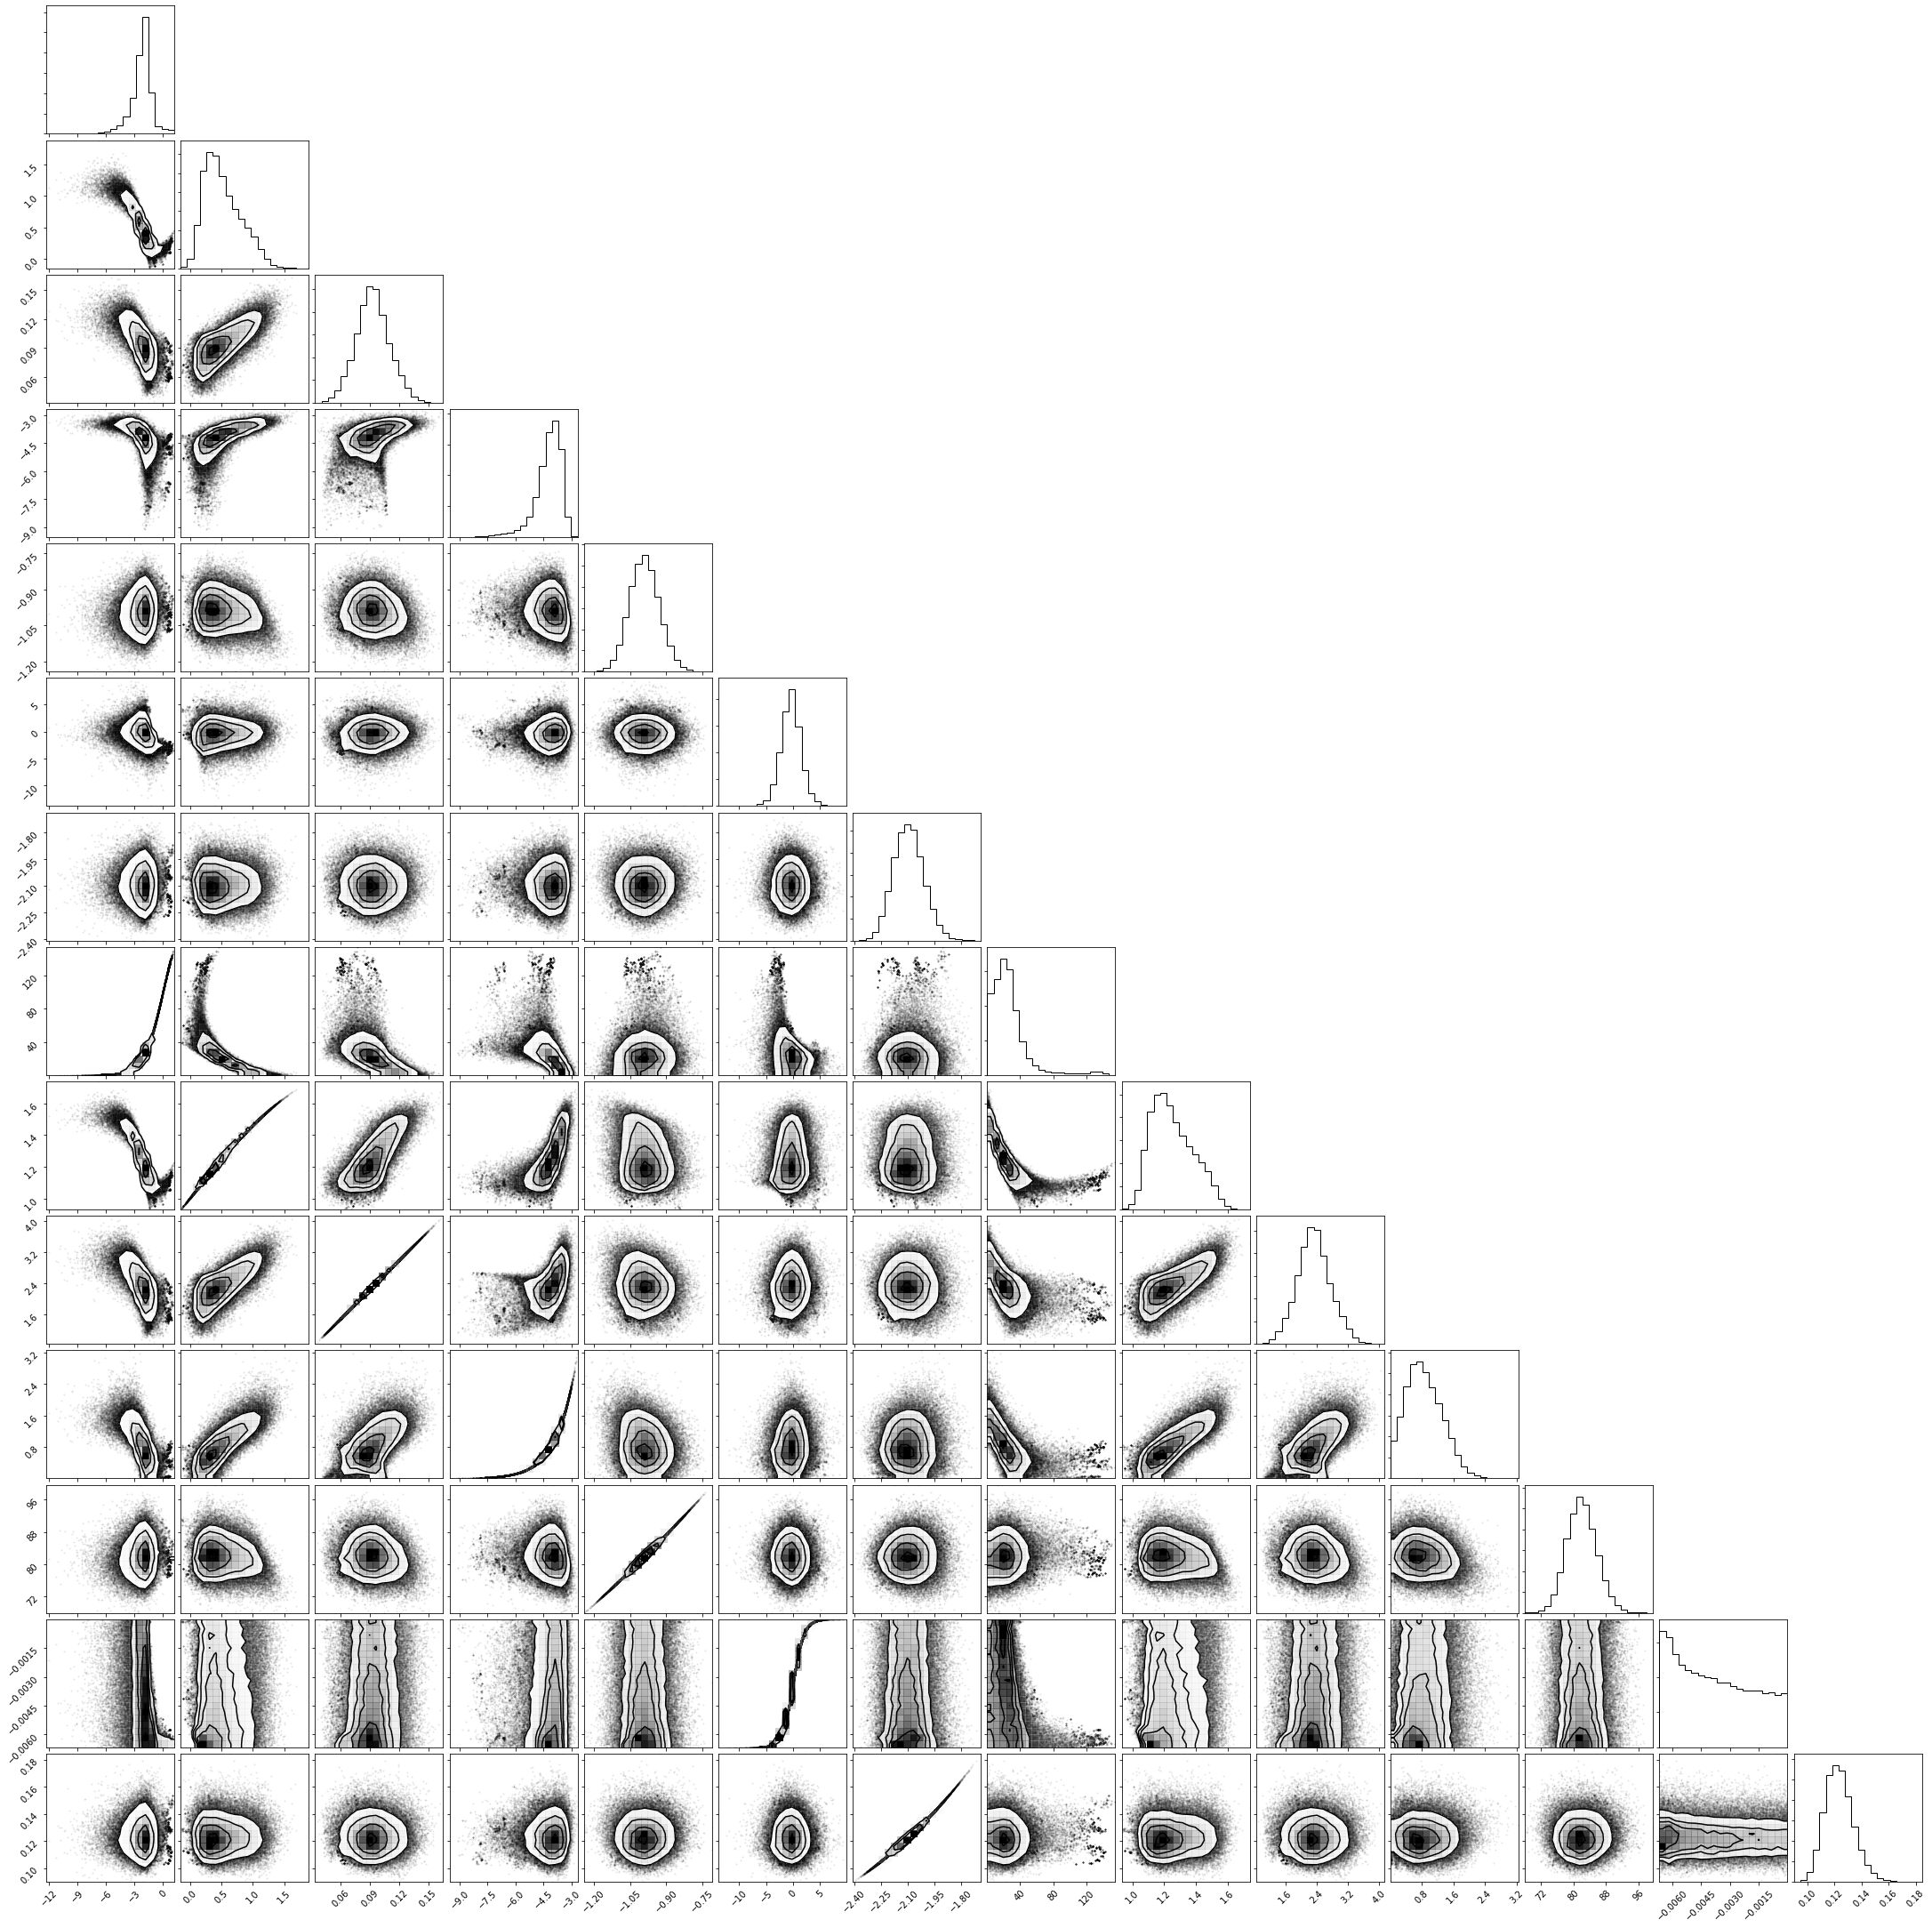

In [39]:
samples = np.vstack([trace_IIp[k] for k in trace_IIp.varnames]).T
corner.corner(samples);